<a href="https://colab.research.google.com/github/kamhar-ngado/Track/blob/master/Program_auto_pilot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [187]:
!git clone https://github.com/kamhar-ngado/Track

fatal: destination path 'Track' already exists and is not an empty directory.


In [188]:
!ls Track

driving_log.csv  IMG  Program_auto_pilot.ipynb	README.md


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import keras 
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import ntpath
import random


In [190]:
datadir = 'Track'
colomns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = colomns)
pd.set_option('display.max_colwidth', -1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\self driving car simulator\IMG\center_2019_12_21_15_25_24_879.jpg,C:\self driving car simulator\IMG\left_2019_12_21_15_25_24_879.jpg,C:\self driving car simulator\IMG\right_2019_12_21_15_25_24_879.jpg,0.0,0.0,0.0,0.000078
1,C:\self driving car simulator\IMG\center_2019_12_21_15_25_25_021.jpg,C:\self driving car simulator\IMG\left_2019_12_21_15_25_25_021.jpg,C:\self driving car simulator\IMG\right_2019_12_21_15_25_25_021.jpg,0.0,0.0,0.0,0.000084
2,C:\self driving car simulator\IMG\center_2019_12_21_15_25_25_128.jpg,C:\self driving car simulator\IMG\left_2019_12_21_15_25_25_128.jpg,C:\self driving car simulator\IMG\right_2019_12_21_15_25_25_128.jpg,0.0,0.0,0.0,0.000078
3,C:\self driving car simulator\IMG\center_2019_12_21_15_25_25_240.jpg,C:\self driving car simulator\IMG\left_2019_12_21_15_25_25_240.jpg,C:\self driving car simulator\IMG\right_2019_12_21_15_25_25_240.jpg,0.0,0.0,0.0,0.000078
4,C:\self driving car simulator\IMG\center_2019_12_21_15_25_25_342.jpg,C:\self driving car simulator\IMG\left_2019_12_21_15_25_25_342.jpg,C:\self driving car simulator\IMG\right_2019_12_21_15_25_25_342.jpg,0.0,0.0,0.0,0.000080


In [191]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2019_12_21_15_25_24_879.jpg,left_2019_12_21_15_25_24_879.jpg,right_2019_12_21_15_25_24_879.jpg,0.0,0.0,0.0,0.000078
1,center_2019_12_21_15_25_25_021.jpg,left_2019_12_21_15_25_25_021.jpg,right_2019_12_21_15_25_25_021.jpg,0.0,0.0,0.0,0.000084
2,center_2019_12_21_15_25_25_128.jpg,left_2019_12_21_15_25_25_128.jpg,right_2019_12_21_15_25_25_128.jpg,0.0,0.0,0.0,0.000078
3,center_2019_12_21_15_25_25_240.jpg,left_2019_12_21_15_25_25_240.jpg,right_2019_12_21_15_25_25_240.jpg,0.0,0.0,0.0,0.000078
4,center_2019_12_21_15_25_25_342.jpg,left_2019_12_21_15_25_25_342.jpg,right_2019_12_21_15_25_25_342.jpg,0.0,0.0,0.0,0.000080


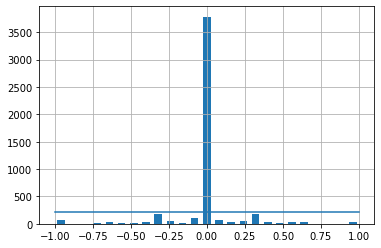

In [192]:
num_bins = 25
samples_per_bin = 210
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
plt.grid()

total data: 4837
removed: 3572
remaining: 1265


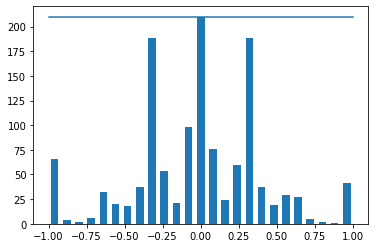

In [193]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))
 
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [194]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings
 
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2019_12_21_15_25_25_445.jpg
left        left_2019_12_21_15_25_25_445.jpg  
right       right_2019_12_21_15_25_25_445.jpg 
steering    0                                 
throttle    0                                 
reverse     0                                 
speed       8.07871e-05                       
Name: 5, dtype: object


In [195]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 3036
Valid Samples: 759


Text(0.5, 1.0, 'Validation set')

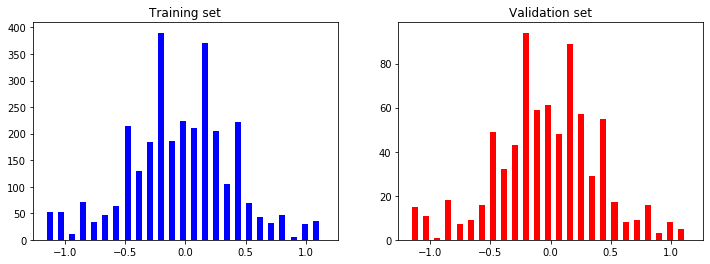

In [141]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [0]:
def img_preprocess(img):
  img = mpimg.imread(img)
  img = img[60:135,:,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

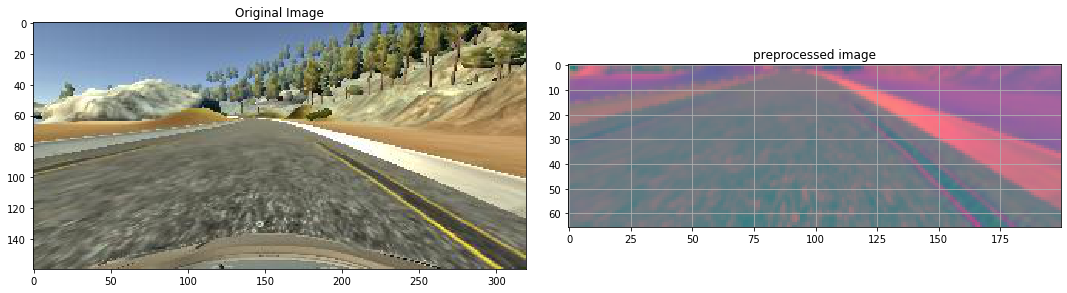

In [185]:
image = image_paths[759] #we can choose img(0 < img < 3795) but 759 is good
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('preprocessed image')
plt.grid()

In [0]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

(3036, 66, 200, 3)


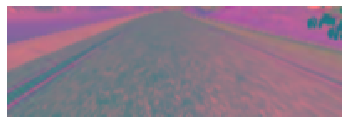

In [199]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1 )])
plt.axis('off')
print(X_train.shape)